In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
from matplotlib.colors import LogNorm, Normalize
from scipy.signal import butter, lfilter, freqz,detrend
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy import constants
#sns.set_theme()
import re
import utils
from scipy import ndimage
from scipy.signal import lfilter

import cv2

# Read data

In [2]:
#Record_2022-09-27_14-14-14.bin
try:
    #with open("felttest2/Record_2022-09-28_14-48-46/Record_2022-09-28_14-48-46.bin", "rb") as f:
    #with open("Record_2022-09-28_15-13-15.bin", "rb") as f:
    with open("felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin", "rb") as f:

        data = f.read()
    
        
        
except IOError as e:
    print(e)

In [3]:
stri = "DONE"
done = False
data_arr = []
index = 0
data_bytes = data
while(not done):
    ls = re.search(stri.encode(), data_bytes).end()
    data_arr.append(data_bytes[:ls])
    data_bytes = data_bytes[ls+4:]
    print(len(data_bytes))
    if(len(data_bytes) == 0):
        done = True

725850672
724801916
723753136
722704392
721655612
720606868
719558112
718509392
717460660
716411904
715363148
714314380
713265588
712216796
711168028
710119236
709070456
708021664
706972884
705924116
704875336
703826556
702777764
701728996
700680192
699631364
698582548
697533708
696484880
695436064
694387248
693338480
692289712
691240944
690192152
689143360
688094604
687045860
685997104
684948312
683899532
682850776
681802008
680753264
679704520
678655776
677606960
676558156
675509412
674460620
673411828
672363072
671314304
670265548
669216780
668168012
667119232
666070428
665021624
663972784
662923992
661875224
660826396
659777604
658728824
657680056
656631300
655582532
654533752
653484972
652436204
651387424
650338680
649289924
648241156
647192424
646143668
645094900
644046132
642997328
641948536
640899756
639850940
638802148
637753368
636704552
635655748
634606992
633558212
632509384
631460580
630411788
629362984
628314180
627265352
626216560
625167780
624118940
623070116
622021256


# Background update algorithem

In [4]:
def simple_exp_smooth(d,extra_periods=1,alpha=0.4):  
  #d = np.array(d)  # Transform the input into a numpy array  
  cols = len(d)  # Historical period length  
  #d = np.append(d,[np.nan]*extra_periods)  # Append np.nan into the demand array to cover future periods  
  f = np.zeros_like(d)  # Forecast array  
  f[0] = d[0]  # initialization of first forecast  
 
  # Create all the t+1 forecasts until end of historical period  
  for t in range(1,cols):  
    f[t] = alpha*d[t]+(1-alpha)*f[t-1]
  #print(f)  
  f[cols+1:] = f[t]  # Forecast for all extra periods  
  #df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f})
  return f,d

In [5]:
c = constants.c
sample_bandwidth  = 191.0153846e6
sample_frek = 2*sample_bandwidth # sample frekuenzy
frame_rate =50*10**(-3) # frame rate
sample_per_frame = 260*257 # sample pr frame
c_t = (1/sample_bandwidth )*256 # sample period
#fs_new = 1/sample_period_new # sample frekuenzy 

In [6]:
def background_update(frames, alpha=1/128, nr_of_ma=1):
    fft_length = 256
    MRDM =np.zeros((len(frames),fft_length,fft_length),dtype=np.complex_)
    
    for i,frame in enumerate(frames):
        length = int.from_bytes(
                 frame[4:8], byteorder="little", signed=False)
        data_RADC = frame[8:8+length]
        data_RADC = np.frombuffer(data_RADC,dtype=np.uint16)
        data_RADC = data_RADC.reshape(3,256,512)
        data_RADC_I_raw = data_RADC[:,:,::2]
        data_RADC_Q_raw = data_RADC[:,:,1::2]
        data_RADC_I = detrend(data_RADC_I_raw, axis=2)
        data_RADC_Q = detrend(data_RADC_Q_raw, axis=2)
        window = signal.windows.hann(256)
        #data_RADC_I_mean = np.mean(data_RADC_I, axis=0)
        #data_RADC_Q_mean = np.mean(data_RADC_Q, axis=0)
        data_RADC_I_mean = data_RADC_I[0]
        data_RADC_Q_mean = data_RADC_Q[0]
        data_IF = window*data_RADC_I_mean[:,:] + window*1j*data_RADC_Q_mean[:,:]
       

        data_range_baseline =utils.fft_and_plot(data_IF, axis=1, fs=sample_frek,fft_size=fft_length,plot=False,shift =False)
        data_range_baseline = utils.MIT_filter( data_range_baseline)
        for j in range(fft_length):
             data_range_baseline[:,j] = window*data_range_baseline[:,j]
        data_doppler_window_slow= utils.fft_and_plot(data_range_baseline, axis=0,fft_size=fft_length,shift =True)
     
        #MRDM[i]=cv2.GaussianBlur(np.abs(data_doppler_window_slow) ,(3, 3),sigmaX=1,sigmaY=1)
        MRDM[i] = data_doppler_window_slow

    #MIT
   
   
    data_diff = MRDM
    raw_frames = MRDM
    for i in range(nr_of_ma):
        MRDM,frames =simple_exp_smooth(data_diff,alpha =alpha)
        data_diff = np.abs(frames) -np.abs(MRDM)
    #data_diff = np.abs(frames[-1]) -np.abs(MRDM[-2])
    utils.CFAR_2D(data_diff[-1].copy(),10, 15, 0.000001,plot=False, iso_axis=True)
    return MRDM,raw_frames,data_diff

In [7]:

idx = 301
data_ma,raw_t,data_diff = background_update(data_arr,nr_of_ma=
4, alpha=1/256)



# Plot moving average

Peak: 124.39642458598344
Side loab: 76.3024340665696
RMS: 89.15416070848235
SNR: 35.24226387750109


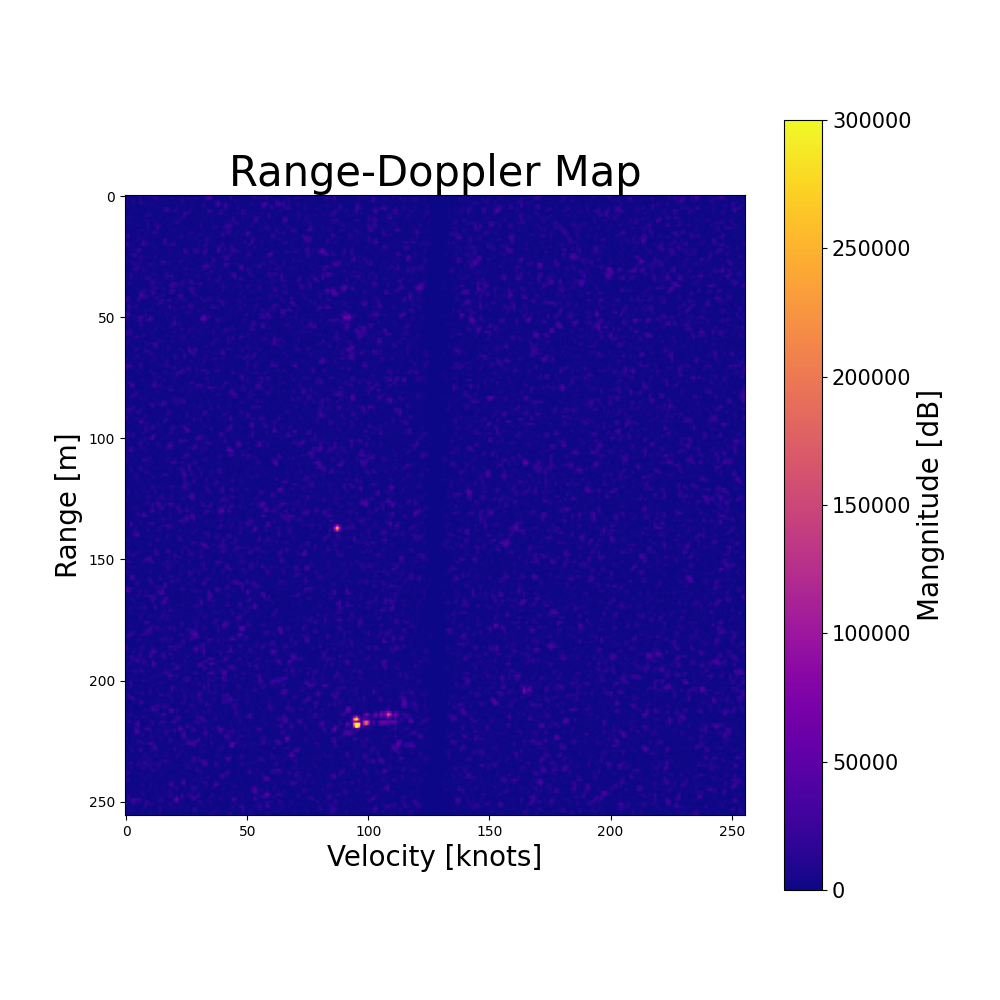

In [8]:
%matplotlib ipympl
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Range-Doppler Map"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
plt.figure(figsize=(10,10))
rotated_img = ndimage.rotate(np.abs(data_diff[450]),90) # We rotate the image so the x axis is the velocity
#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
plt.imshow(rotated_img,cmap="plasma", vmin=0,vmax=300000)
rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
peak = 10*np.log(np.abs(rotated_img[137,87]))
snr = peak-rms
print("Peak:",peak)
print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
print("RMS:",rms)
print("SNR:",snr) 
#plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)


#plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)

# Plot Fitler frames

In [19]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

fig=plt.figure()
ax1=fig.add_subplot(1,1,1)

def animate(i):
    rotated_img = ndimage.rotate(data_diff[i],90)
    ax1.imshow(rotated_img,cmap="plasma", vmin=0,vmax=300000)
    ax1.set_title(f"Frame: {i}")
    ax1.set_xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
    ax1.set_yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
    ax1.autoscale(enable=True, axis='both')

ani = FuncAnimation(fig, animate,600 ,interval=100,cache_frame_data=False)
#plt.show()

NameError: name 'sfsd' is not defined

In [20]:
ani =1

# Calculate and plot CFAR

In [30]:
cfar_array= []
length_data_diff = len(data_diff[100:500])
for i,img in enumerate( data_diff[100:500]):
    cfar ,y,x = utils.CFAR_2D(img,10, 15, 0.000001,plot=False, iso_axis=True)
    cfar_array.append(cfar)
    print(np.round(i/length_data_diff*100,1))

0.0
0.2
0.5
0.8
1.0
1.2
1.5
1.8
2.0
2.2
2.5
2.8
3.0
3.2
3.5
3.8
4.0
4.2
4.5
4.8
5.0
5.2
5.5
5.8
6.0
6.2
6.5
6.8
7.0
7.2
7.5
7.8
8.0
8.2
8.5
8.8
9.0
9.2
9.5
9.8
10.0
10.2
10.5
10.8
11.0
11.2
11.5
11.8
12.0
12.2
12.5
12.8
13.0
13.2
13.5
13.8
14.0
14.2
14.5
14.8
15.0
15.2
15.5
15.8
16.0
16.2
16.5
16.8
17.0
17.2
17.5
17.8
18.0
18.2
18.5
18.8
19.0
19.2
19.5
19.8
20.0
20.2
20.5
20.8
21.0
21.2
21.5
21.8
22.0
22.2
22.5
22.8
23.0
23.2
23.5
23.8
24.0
24.2
24.5
24.8
25.0
25.2
25.5
25.8
26.0
26.2
26.5
26.8
27.0
27.3
27.5
27.8
28.0
28.2
28.5
28.7
29.0
29.2
29.5
29.8
30.0
30.2
30.5
30.8
31.0
31.2
31.5
31.8
32.0
32.2
32.5
32.8
33.0
33.2
33.5
33.8
34.0
34.2
34.5
34.8
35.0
35.2
35.5
35.8
36.0
36.2
36.5
36.8
37.0
37.2
37.5
37.8
38.0
38.2
38.5
38.8
39.0
39.2
39.5
39.8
40.0
40.2
40.5
40.8
41.0
41.2
41.5
41.8
42.0
42.2
42.5
42.8
43.0
43.2
43.5
43.8
44.0
44.2
44.5
44.8
45.0
45.2
45.5
45.8
46.0
46.2
46.5
46.8
47.0
47.2
47.5
47.8
48.0
48.2
48.5
48.8
49.0
49.2
49.5
49.8
50.0
50.2
50.5
50.7
51.0
51.2
51.5
51.7


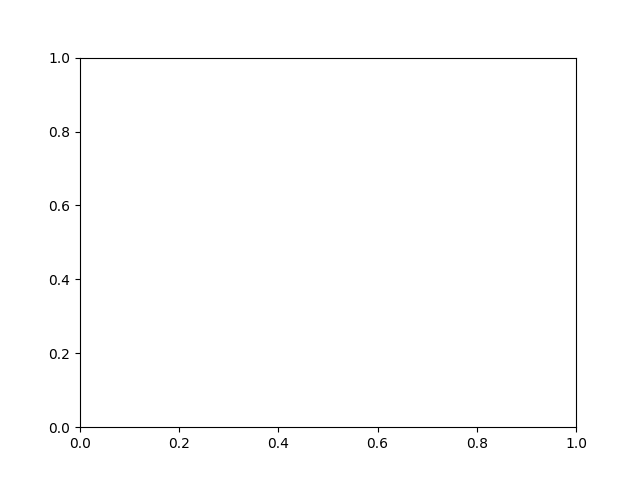

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x7fc3c4dc01d0>>
Traceback (most recent call last):
  File "/Users/sondreolimb/prosjektOppgave/ProjectReportCode/env/lib/python3.7/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/sondreolimb/prosjektOppgave/ProjectReportCode/env/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1198, in _on_timer
    ret = func(*args, **kwargs)
  File "/Users/sondreolimb/prosjektOppgave/ProjectReportCode/env/lib/python3.7/site-packages/matplotlib/animation.py", line 1406, in _step
    still_going = super()._step(*args)
  File "/Users/sondreolimb/prosjektOppgave/ProjectReportCode/env/lib/python3.7/site-packages/matplotlib/animation.py", line 1105, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/Users/sondreolimb/prosjektOppgave/ProjectReportCode/env/lib/python3.7/site-packages/matp

In [39]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

fig_cfar=plt.figure()
ax1_cfar=fig_cfar.add_subplot(1,1,1)



def animate_cfar(i):
    rotated_img = ndimage.rotate(cfar_array[i],90)
    ax1_cfar.imshow(rotated_img,cmap="plasma", vmin=0,vmax=300000)
    ax1_cfar.set_title(f"Frame: {i}")
    ax1_cfar.set_xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
    ax1_cfar.set_yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
    ax1_cfar.autoscale(enable=True, axis='both')

ani_cfar = FuncAnimation(fig_cfar, animate_cfar, interval=100)
plt.show()

Peak: 11480.42917902049
RMS: 3102.3406331391598
SNR: 5.682686427391085


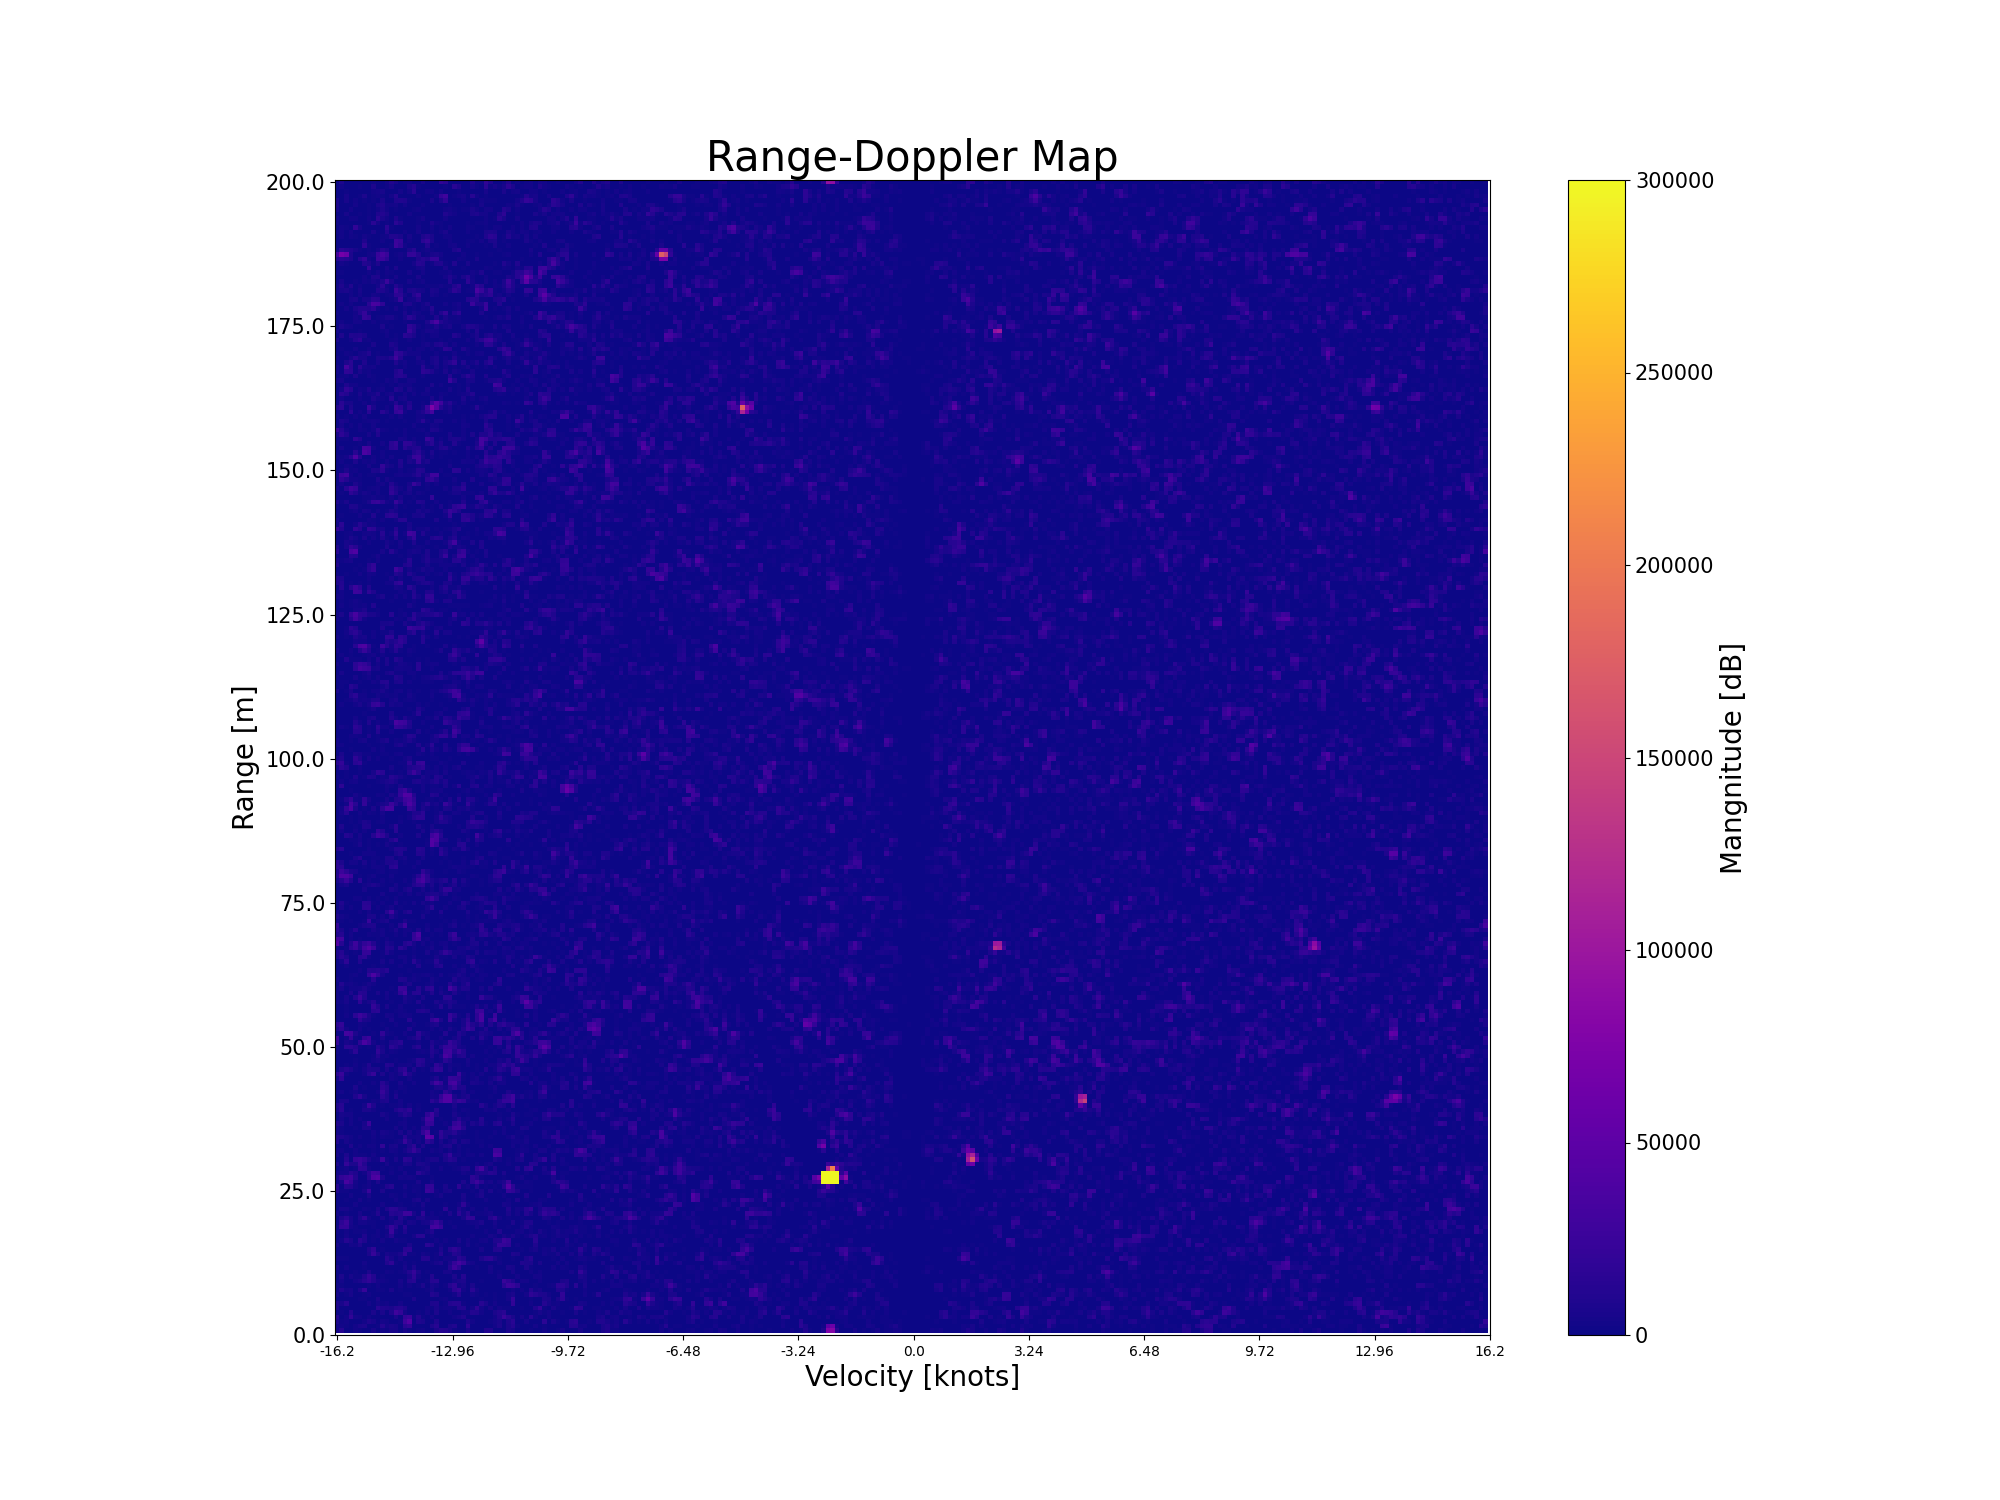

In [32]:
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Range-Doppler Map"

}
#data_fft_plot = cv2.GaussianBlur(data_diff[-1], (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
plt.figure(figsize=(20,15))
rotated_img = ndimage.rotate(data_diff[-1],90) # We rotate the image so the x axis is the velocity
#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
plt.imshow(rotated_img,cmap="plasma", vmin=0,vmax=300000,)
rms = np.sqrt(np.mean(rotated_img[139,:])**2)
peak = rotated_img[137,87]
snr = 10*np.log10(peak/rms)
print("Peak:",peak)
print("RMS:",rms)
print("SNR:",snr)
plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
#plt.xlim(60,100)
#plt.ylim(130,150)
plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)

# Baseline, No MA

Peak: 40365.990036702875
RMS: 21825.741603570124
SNR: 2.6704659942055016


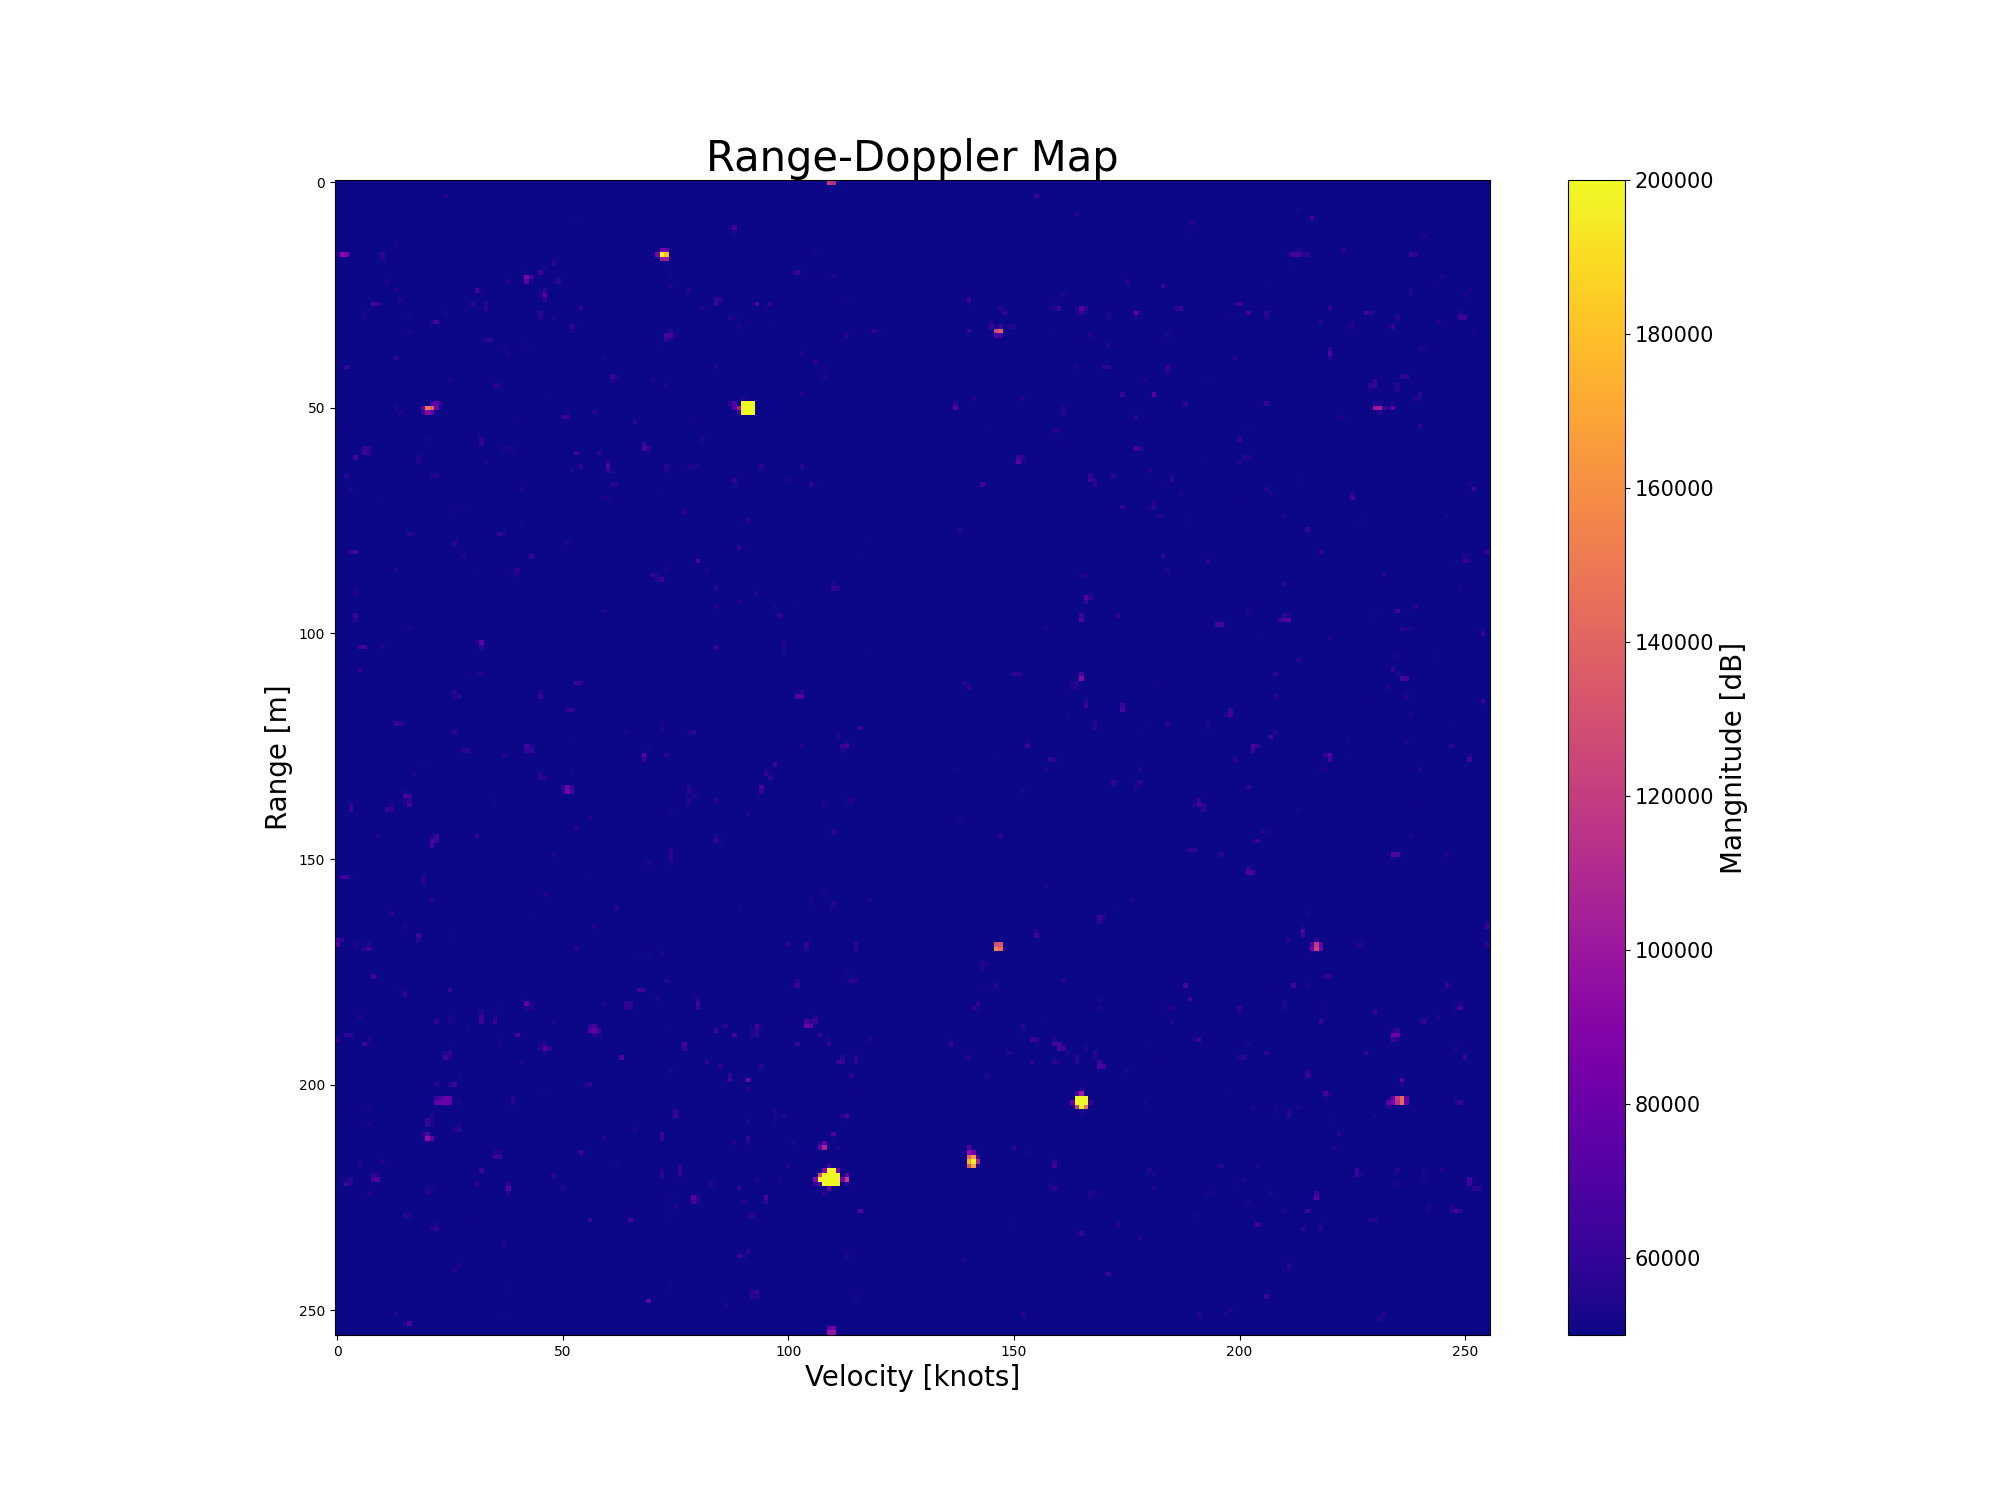

In [33]:
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Range-Doppler Map"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
plt.figure(figsize=(20,15))
rotated_img = ndimage.rotate(np.abs(raw_t[-1]),90) # We rotate the image so the x axis is the velocity
plt.imshow(rotated_img,cmap="plasma",  vmin=50000,vmax=200000)
rms = np.sqrt(np.mean(rotated_img[139,:])**2)
peak = rotated_img[137,87]
snr = 10*np.log10(peak/rms)
print("Peak:",peak)
print("RMS:",rms)
print("SNR:",snr)
#plt.yticks(np.linspace(0,256,5),labels=np.round(np.linspace(255*0.785277,0,5)),size =15)


#plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2)
#plt.xlim(85,90)
#plt.ylim(135,140)
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)